# Gradient Boosting Machines (GBMs) with XGBoost

In [1]:
import matplotlib
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import opendatasets as od
import numpy as np

%matplotlib inline

sns.set_style("darkgrid")
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [2]:
ross_df = pd.read_csv('./rossmann-store-sales/train.csv', low_memory=False)
store_df = pd.read_csv('./rossmann-store-sales/store.csv')
test_df = pd.read_csv('./rossmann-store-sales/test.csv')

In [3]:
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [4]:
merged_df = ross_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left',  on='Store')

In [5]:
print(merged_df.columns)

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')


## Preprocessing and Feature 

In [6]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [7]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [8]:
split_date(merged_df)
split_date(merged_test_df)

In [9]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,...,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,...,4.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,...,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,...,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


## Store Open/Closed

In [10]:
merged_df[merged_df.Open == 0].Sales.value_counts()

Sales
0    172817
Name: count, dtype: int64

In [11]:
merged_df = merged_df[merged_df.Open == 1].copy()

## Competition

In [12]:
merged_df.sample(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
340929,918,4,2014-09-11,4307,531,1,0,0,0,a,...,4.0,2015.0,0,NaN,NaN,NaN,2014,9,11,37
760167,523,1,2013-08-19,17746,2153,1,0,0,0,c,...,11.0,2013.0,0,NaN,NaN,NaN,2013,8,19,34
544439,1105,6,2014-03-01,4730,535,1,0,0,0,c,...,11.0,2008.0,1,5.0,2013.0,"Feb,May,Aug,Nov",2014,3,1,9
491004,75,4,2014-04-17,9449,895,1,1,0,1,d,...,12.0,2013.0,0,NaN,NaN,NaN,2014,4,17,16
346231,546,5,2014-09-05,13674,1674,1,1,0,0,a,...,1.0,2005.0,0,NaN,NaN,NaN,2014,9,5,36
912111,827,5,2013-04-05,9784,1385,1,0,0,1,a,...,1.0,2005.0,0,NaN,NaN,NaN,2013,4,5,14
951678,254,4,2013-02-28,2286,218,1,0,0,0,d,...,3.0,2008.0,1,1.0,2012.0,"Mar,Jun,Sept,Dec",2013,2,28,9
879482,533,6,2013-05-04,6996,625,1,0,0,0,a,...,NaN,NaN,0,NaN,NaN,NaN,2013,5,4,18
809210,506,6,2013-07-06,4774,581,1,0,0,0,a,...,12.0,2014.0,1,18.0,2011.0,"Feb,May,Aug,Nov",2013,7,6,27
267237,3,5,2014-11-28,9700,953,1,1,0,0,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2014,11,28,48


In [13]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    # If Competition was opened early and it's in the negatives -- check it and return 0 else the number itself
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [14]:
comp_months(merged_df)
comp_months(merged_test_df)

In [15]:
# merged_df.CompetitionOpen.describe()

In [16]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [17]:
promo_cols(merged_df)
promo_cols(merged_test_df)

In [18]:
merged_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(20)

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
715415,2013-09-28,1,2014.0,45.0,"Feb,May,Aug,Nov",0.000000,0
904197,2013-04-12,0,NaN,NaN,NaN,0.000000,0
26475,2015-07-08,0,NaN,NaN,NaN,0.000000,0
575236,2014-02-01,0,NaN,NaN,NaN,0.000000,0
411186,2014-06-28,1,2012.0,1.0,"Jan,Apr,Jul,Oct",29.737705,0
192056,2015-02-09,1,2009.0,31.0,"Feb,May,Aug,Nov",66.491803,1
920268,2013-03-28,1,2013.0,14.0,"Jan,Apr,Jul,Oct",0.000000,0
32204,2015-07-03,1,2010.0,13.0,"Jan,Apr,Jul,Oct",63.213115,1
317601,2014-10-06,1,2009.0,37.0,"Jan,Apr,Jul,Oct",60.918033,1
9597,2015-07-23,1,2011.0,40.0,"Jan,Apr,Jul,Oct",45.704918,1


## Input and Target Columns

In [19]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [20]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [21]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

In [22]:
test_inputs = merged_test_df[input_cols].copy()

In [23]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

In [24]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

In [25]:
max_distance = inputs.CompetitionDistance.max()
max_distance

np.float64(75860.0)

In [26]:
inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance, inplace=True)

C:\Users\Kelvin Mhacwilson\AppData\Local\Temp\ipykernel_7040\751725973.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
C:\Users\Kelvin Mhacwilson\AppData\Local\Temp\ipykernel_7040\751725973.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

## Scaling Numeric Values

In [27]:
from sklearn.preprocessing import MinMaxScaler

In [28]:
scaler = MinMaxScaler()

In [29]:
scaler.fit(inputs[numeric_cols])

MinMaxScaler()

In [30]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [31]:
inputs[numeric_cols].describe()

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,Day,Month,Year,WeekOfYear
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,0.500380,0.446352,0.193580,0.074107,0.030270,0.498684,0.181163,0.148902,0.494523,0.440522,0.415969,0.444055
std,0.288808,0.497114,0.395103,0.113142,0.047034,0.499999,0.263713,0.355992,0.289449,0.302176,0.388630,0.282153
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250449,0.000000,0.000000,0.009098,0.000000,0.000000,0.000000,0.000000,0.233333,0.181818,0.000000,0.196078
50%,0.500000,0.000000,0.000000,0.030459,0.011544,0.000000,0.000000,0.000000,0.500000,0.454545,0.500000,0.431373
75%,0.750449,1.000000,0.000000,0.090849,0.052670,1.000000,0.346084,0.000000,0.733333,0.636364,0.500000,0.666667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Encode Categorical Columns

In [32]:
from sklearn.preprocessing import OneHotEncoder

In [33]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [34]:
encoded_cols = encoder.get_feature_names_out(categorical_cols).tolist()
# encoded_cols

In [35]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [36]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [37]:
X

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,Day,Month,...,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,0.000000,1.0,1.0,0.016482,0.059163,0.0,0.000000,0.0,1.0,0.545455,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.000898,1.0,1.0,0.007252,0.066378,1.0,0.890710,1.0,1.0,0.545455,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.001795,1.0,1.0,0.186050,0.074315,1.0,0.720856,1.0,1.0,0.545455,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.002693,1.0,1.0,0.007911,0.050505,0.0,0.000000,0.0,1.0,0.545455,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.003591,1.0,1.0,0.394119,0.002165,0.0,0.000000,0.0,1.0,0.545455,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,0.611311,0.0,1.0,0.001714,0.054834,0.0,0.000000,0.0,0.0,0.000000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1016827,0.657092,0.0,1.0,0.011076,0.114719,0.0,0.000000,0.0,0.0,0.000000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1016863,0.689408,0.0,1.0,0.010812,0.000000,1.0,0.016849,1.0,0.0,0.000000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1017042,0.850090,0.0,1.0,0.018592,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Gradient Boosting

### Training

In [38]:
from xgboost import XGBRegressor

In [39]:
model = XGBRegressor(random_state=42, n_jobs=-1, max_depth=4, n_estimators=20)

In [40]:
model.fit(X, targets)

C:\Users\Kelvin Mhacwilson\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

### Prediction

In [41]:
preds = model.predict(X)
preds

array([ 7960.1133,  7581.974 ,  7993.401 , ...,  7101.1714,  8794.572 ,
       10820.442 ], dtype=float32)

In [42]:
from sklearn.metrics import root_mean_squared_error

In [43]:
def rmse(a, b):
    return root_mean_squared_error(a, b)

In [44]:
rmse(preds, targets)

2397.161376953125

### Visualization

In [45]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 30,30

In [46]:
# plot_tree(model, rankdir='LR')

In [47]:
# plot_tree(model, rankdir='LR', num_trees=1)

In [48]:
trees = model.get_booster().get_dump()

In [49]:
len(trees)

20

In [50]:
print(trees[0])

0:[Promo<1] yes=1,no=2,missing=2
	1:[StoreType_b<1] yes=3,no=4,missing=4
		3:[Assortment_a<1] yes=7,no=8,missing=8
			7:[CompetitionDistance<0.00448312238] yes=15,no=16,missing=16
				15:leaf=223.091629
				16:leaf=-263.189026
			8:[WeekOfYear<0.921568632] yes=17,no=18,missing=18
				17:leaf=-467.055237
				18:leaf=-83.930191
		4:[CompetitionDistance<0.015822785] yes=9,no=10,missing=10
			9:[CompetitionDistance<0.0117352316] yes=19,no=20,missing=20
				19:leaf=654.354065
				20:leaf=3492.14575
			10:[DayOfWeek_7<1] yes=21,no=22,missing=22
				21:leaf=-187.357132
				22:leaf=877.194702
	2:[DayOfWeek_1<1] yes=5,no=6,missing=6
		5:[Month<1] yes=11,no=12,missing=12
			11:[StoreType_b<1] yes=23,no=24,missing=24
				23:leaf=208.808884
				24:leaf=1208.23828
			12:[Day<0.200000003] yes=25,no=26,missing=26
				25:leaf=668.335449
				26:leaf=1160.14038
		6:[Month<1] yes=13,no=14,missing=14
			13:[CompetitionDistance<0.00276898732] yes=27,no=28,missing=28
				27:leaf=1261.60889
				28:leaf=752.9

### Feature Importance

In [51]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [52]:
importance_df.head(10)

,feature,importance
1,Promo,0.334846
12,DayOfWeek_1,0.076257
24,StoreType_b,0.069301
5,Promo2,0.052821
26,StoreType_d,0.051002
9,Month,0.036114
27,Assortment_a,0.034672
11,WeekOfYear,0.034646
29,Assortment_c,0.034157
3,CompetitionDistance,0.030939


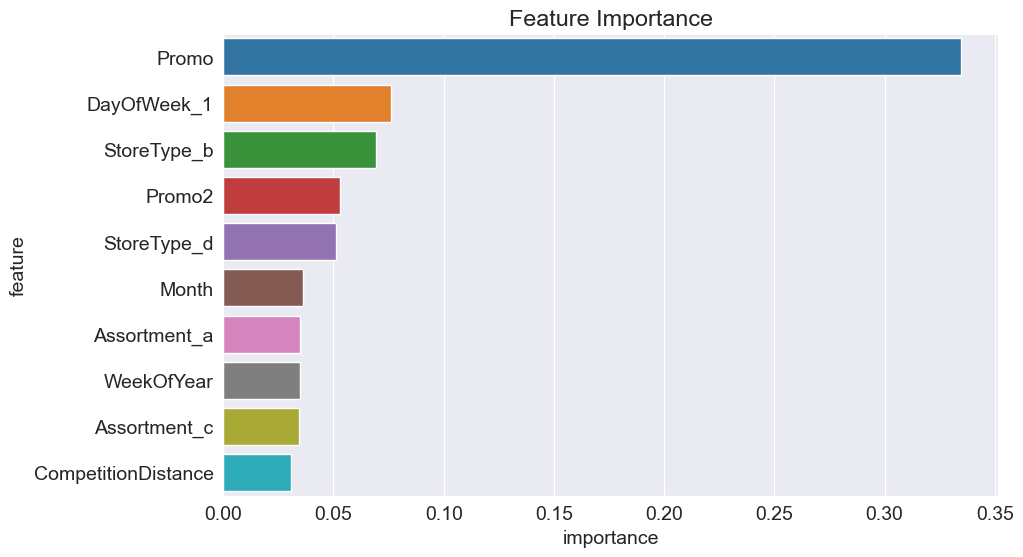

In [53]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature', hue='feature');

## K Fold Cross Validation

In [54]:
from sklearn.model_selection import KFold

In [55]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse 

In [56]:
kfold = KFold(n_splits=5)

In [57]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(
        X_train,
        train_targets,
        X_val,
        val_targets,
        max_depth =4,
        n_estimators = 20
    )
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

Train RMSE: 2394.787841796875, Validation RMSE: 2462.850341796875
Train RMSE: 2401.158203125, Validation RMSE: 2449.841796875
Train RMSE: 2411.892822265625, Validation RMSE: 2391.591064453125
Train RMSE: 2344.831298828125, Validation RMSE: 2440.04443359375
Train RMSE: 2391.154541015625, Validation RMSE: 2460.874267578125


In [58]:
import numpy as np

In [59]:
def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [60]:
preds = predict_avg(models, X)

In [61]:
(models[0].predict(X) + models[1].predict(X)) / 2

array([8281.003 , 7584.3584, 8723.686 , ..., 7292.9873, 7581.457 ,
       9300.3125], dtype=float32)

In [62]:
preds

array([8031.8696, 7536.164 , 8671.131 , ..., 7181.968 , 7955.146 ,
       9629.75  ], dtype=float32)

### Hyperparameter Tuning and Regularization

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [65]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

#### n_estimators

In [66]:
test_params(n_estimators=10)

Train RMSE: 2329.90771484375, Validation RMSE: 2325.4580078125


In [67]:
test_params(n_estimators=30)

Train RMSE: 1867.089599609375, Validation RMSE: 1869.401123046875


In [68]:
test_params(n_estimators=100)

Train RMSE: 1182.891357421875, Validation RMSE: 1198.0689697265625


In [69]:
test_params(n_estimators=240)

Train RMSE: 905.85888671875, Validation RMSE: 934.659912109375


#### max_depth

In [70]:
test_params(max_depth=2)

Train RMSE: 2384.473876953125, Validation RMSE: 2377.173828125


In [71]:
test_params(max_depth=5)

Train RMSE: 1408.7918701171875, Validation RMSE: 1417.241455078125


In [72]:
test_params(max_depth=10)

Train RMSE: 676.5131225585938, Validation RMSE: 787.7642211914062


#### `learning_rate`

Alpha applied to the decision tree -- for scale

In [73]:
test_params(n_estimators=50, learning_rate=0.01)

Train RMSE: 2788.614013671875, Validation RMSE: 2792.76171875


In [74]:
test_params(n_estimators=50, learning_rate=0.1)

Train RMSE: 2177.87158203125, Validation RMSE: 2172.677001953125


In [75]:
test_params(n_estimators=50, learning_rate=0.3)

Train RMSE: 1555.5303955078125, Validation RMSE: 1561.56982421875


In [76]:
test_params(n_estimators=50, learning_rate=0.9)

Train RMSE: 1155.777099609375, Validation RMSE: 1175.184814453125


In [77]:
test_params(n_estimators=50, learning_rate=0.99)

Train RMSE: 1167.662109375, Validation RMSE: 1192.436767578125


#### `booster`

uses linear regression model

In [78]:
test_params(booster='gblinear')

Train RMSE: 2726.08251953125, Validation RMSE: 2726.795654296875


## Putting it Together and Making Predictions

In [79]:
model = XGBRegressor(n_jobs=-1, 
                     random_state=42, 
                     n_estimators=1000, 
                     learning_rate=0.2, 
                     max_depth=10, 
                     subsample=0.9, 
                     colsample_bytree=0.7
                    )

In [80]:
model.fit(X, targets)

C:\Users\Kelvin Mhacwilson\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [81]:
test_preds = model.predict(X_test)

In [82]:
train_rmse = rmse(model.predict(X_train), train_targets)
val_rmse = rmse(model.predict(X_val), val_targets)
print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

Train RMSE: 382.5062255859375, Validation RMSE: 383.83270263671875


## Submitting

In [83]:
submission_df = pd.read_csv('./rossmann-store-sales/sample_submission.csv')

In [84]:
submission_df['Sales']  = test_preds

In [85]:
test_df.Open.isna().sum()

np.int64(11)

In [86]:
submission_df['Sales'] = submission_df['Sales'] * test_df.Open.fillna(1.)

In [87]:
submission_df[submission_df.Sales ==0].value_counts().sum()

np.int64(5984)

In [88]:
submission_df.to_csv('submission.csv', index=None)